# Adiabatic Work Stroke
How can we simulate a positive work adiabatic stroke?
The temperature of the system should dimish while its entropy is held constant.
In theory, this should amounts to transitioning from an Hamiltonian $H=\hbar\omega \hat{n}$ to $H'=\hbar\omega'\hat{n}$.
From the Liouville-Von Neumann equation:
$$
\frac{d\rho}{dt} = -i[H, \rho]
$$
and maybe (TO BE VERIFYIED)
$$
\frac{d\rho(t)}{dt} = -i[H(t), \rho(t)]
$$

We need an Hamiltonian representing an **Adiabatic Expansion** which depletes internal system energy. 
This should be done by changing the frequency of the system from $\omega_1$ to $\omega_2$, going from $H_1 = \hbar\omega_1\hat{n}$ to $H_2 = \hbar\omega_2\hat{n}$.

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
import tqdm
import copy

from thermophaseonium.utilities.states import Cavity, Ancilla

SEED = 42
rng = np.random.default_rng(SEED)

OMEGA = 0.5  # Interaction strength

N = 250  # Maximum number of dimensions

INTERACTION_TIME = 0.02
T_MAX = 100
TIMESTEPS = np.linspace(0, T_MAX, int(T_MAX / INTERACTION_TIME))
print(f"Total of {len(TIMESTEPS)} timesteps from 0 to {T_MAX} with dt = {INTERACTION_TIME}")

Total of 5000 timesteps from 0 to 100 with dt = 0.02


In [26]:
def photons_from_temperature(T, omega):
    return 1 / (np.exp(omega / T) - 1)
    
TEMPERATURE_TO_PHOTON_MAP = {
    0.5: 0.156518,
    1.0: 0.5819767068693264,
    1.5: 1.0551483399,
    2.0: 1.541494082537,
}

OMEGA1 = 1.0
OMEGA2 = 10.0

system_temperature = 10
n_photons = photons_from_temperature(system_temperature, OMEGA1)
system = Cavity(qt.thermal_dm(N, n_photons), omega=1)

system.temperature

9.999999999999982

In [27]:
def H_work(a, omega1, omega2, t):
    h1 = (omega1 * a)
    h2 = (omega2 * a.dag())
    h_t = (1 -  t/T_MAX) * h1 + (t/T_MAX) * h2
    h = 0.1 * omega2 * a
    return h + h.dag()

In [28]:
def D(op1, rho, op2=None):
    if op2 is None:
        op2 = op1
    return op1 * rho * op2.dag() - qt.commutator(op2.dag() * op1, rho, kind='anti') / 2

In [29]:
def onestep_evolution(rho, dt, a, omega1, omega2, t):
    work = - 1j * dt * qt.commutator(H_work(a, omega1, omega2, t), rho)
    rho_new = rho + work
    return rho_new

In [30]:
def hilbert_is_good(rho, threshold=1e-6):
    """
    Check if the last element of the density matrix is almost null
    """
    return 0 <= abs(rho[-1, -1]) < threshold

In [9]:
def evolve(rho, timesteps, omega1: float, omega2: float):
    a = qt.destroy(rho.dims[0][0])
    dt = INTERACTION_TIME
    
    temperature_evolution = np.zeros(len(timesteps))
    entropy_evolution = np.zeros(len(timesteps))
    
    for k, t in enumerate(tqdm.tqdm(timesteps)):
        temperature_evolution[k] = rho.temperature
        entropy_evolution[k] = rho.entropy
        try:
            rho_new = Cavity(onestep_evolution(rho, dt, a, omega1, omega2, t))
        except ValueError as e:
            print(f"Error creating the evolved system at step {k}: ", e)
            return rho, temperature_evolution[:k], entropy_evolution[:k]
        
        if not hilbert_is_good(rho_new):
            print(f"Invalid Hilbert space truncation at step {k}")
            return rho, temperature_evolution[:k], entropy_evolution[:k]
        
        # Update the system
        rho = rho_new
        
    return rho, temperature_evolution, entropy_evolution

In [8]:
rho = copy.deepcopy(system)
rho, temperatures, entropies = evolve(rho, TIMESTEPS, OMEGA1, OMEGA2)

  2%|▏         | 90/5000 [00:04<03:41, 22.16it/s]

Invalid Hilbert space truncation at step 90


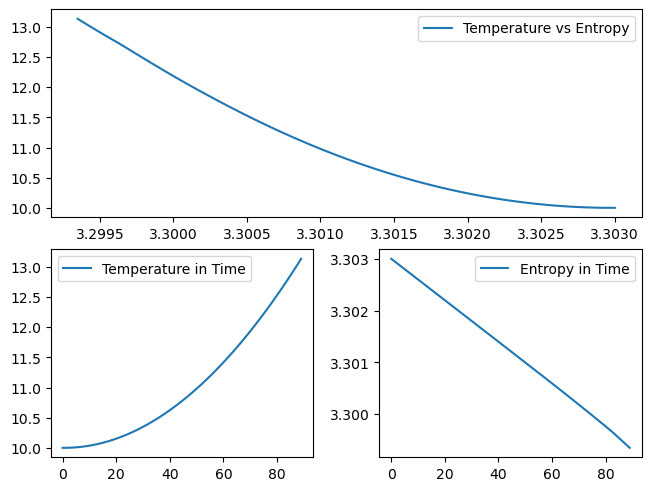

In [9]:
fig, axs = plt.subplot_mosaic([['ST', 'ST'], ['T', 'S']], layout='constrained')

axs['ST'].plot(entropies, temperatures, label='Temperature vs Entropy')
axs['T'].plot(temperatures, label='Temperature in Time')
axs['S'].plot(entropies, label='Entropy in Time')
axs['ST'].legend()
axs['T'].legend()
axs['S'].legend()
plt.show()

# Adiabatic Expansion
*per Tjero et al., 2024*

In the adiabatic expansion the evolution is unitary and given by:
$$
U_k\rho(t)U_k^\dagger,
$$
where
$$
U_k = \exp\left(-i\int_{t_{k}}^{t_{k+1}} H_k(t')dt'\right).
$$

In [73]:
def H_at_time(t, ndims=N):
    v = 100
    l_t = 10 + v*t
    omega_t  = 1 / l_t
    return omega_t * (qt.destroy(ndims)*qt.create(ndims) + 1/2)

In [74]:
def integrate_H(ti, tf):
    steps = 10000
    timesteps = np.linspace(ti, tf, steps)
    dt = 1 / steps
    return sum(H_at_time(t)*dt for t in timesteps)

In [75]:
U = (-1j * integrate_H(0, 100)).expm()

9.999999999999982


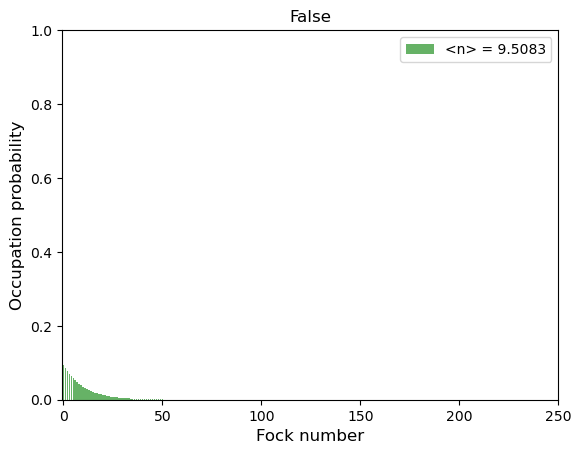

In [76]:
rho = copy.deepcopy(system)
print(rho.temperature)

In [77]:
rho = Cavity(U * rho * U.dag())
print(rho.temperature)
rho.plot_fock_distribution()

10.00000000000002


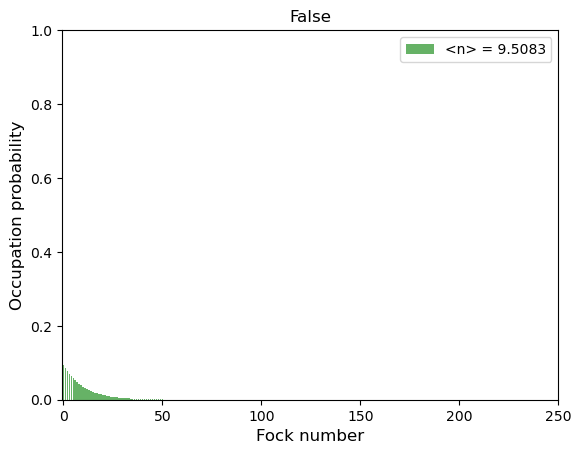